# Importación de módulos generales

In [30]:
%pylab inline

import os
import tempfile
import pandas as pd
# import numpy as np
import networkx as nx
# import matplotlib
# import pylab  as plt
import pygraphviz

Populating the interactive namespace from numpy and matplotlib


# Definición de parámetros

In [31]:
# Número de bins o contenedores para discretizar los datos
num_bins = 18


# Estaciones y variables a usar en cada una
# variables = ['CO', 'NO2', 'NOX', 'SO2', 'O3', 'TMP', 'DV', 'VV', 'HR']
# stations = ['Merced', 'Pedregal', 'Tlalnepantla', 'Xalostoc']

variables = ['CO', 'NO2', 'NOX', 'SO2', 'O3']
stations = ['Merced', 'Pedregal']

# Funciones auxiliares

In [32]:
# Dibujar los modelos de pomegranate haciendo uso de la librería NetworkX
# def plot_pomegranate_bn_nx(pgm):
#     edges = []
#     for i, pair in enumerate(pgm.structure):
#         if pair:
#             edges.append((pair[0],i))

#     G = nx.DiGraph()
#     G.add_edges_from(edges)
#     layout = nx.shell_layout(G)
#     nx.draw(G, pos=layout, with_labels=True, node_size=1000, node_color="pink")
#     plt.show()
    
def plot_pomegranate_bn_nx(pgm):
    G = nx.DiGraph()
    for parent, child in pgm.edges:
        G.add_edge(parent.name, child.name)

    layout = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos=layout, with_labels=True, node_size=2000, node_color="pink")
    plt.show()
    
    
# Dibujar los modelos de pomegranate haciendo uso de la librería GraphViz
def plot_pomegranate_bn_pgvz(pgm, filename=None):
    if pygraphviz is not None:
        G = pygraphviz.AGraph(directed=True)

        for state in pgm.states:
            G.add_node(state.name, color='red')

        for parent, child in pgm.edges:
            G.add_edge(parent.name, child.name)
        
        if filename is None:
            tf = os.path.join(tempfile._get_default_tempdir(), next(tempfile._get_candidate_names())+'.png')
            G.draw(tf, format='png', prog='dot')
            img = matplotlib.image.imread(tf)
            plt.imshow(img)
            plt.axis('off')
            os.unlink(tf)
        else:
            G.draw(filename, format='pdf', prog='dot')

    else:
        raise ValueError("must have pygraphviz installed for visualization")

# Carga de los datos de SINAICA

In [26]:
data = pd.read_csv("data/sinaica/2019-01/Datos SINAICA - Merced - CO - 2019-01-01 - 2019-02-01.csv")
# print(data.columns)
# print(data['Parámetro'][0])
data = data.drop(columns=['Parámetro', 'Valor', 'Unidad'])

# print('Initial data\n')
# print(data)

for st in stations:
    for var in variables:
        df = pd.read_csv("data/sinaica/2019-01/Datos SINAICA - {} - {} - 2019-01-01 - 2019-02-01.csv".format(st, var))
        param = '{}_{}'.format(df['Parámetro'][0], st[0])
        df.rename(columns={"Valor": param}, inplace=True)
        df[param] = pd.cut(df[param], bins=num_bins)
        df = df.drop(columns=['Parámetro', 'Unidad'])
        data = data.merge(df, how='outer', on=['Fecha','Hora'])
        
complete_data = data.dropna().drop(columns=['Fecha'])
binned_data = complete_data

# binned_data['CO_M'] = pd.cut(binned_data, bins=20)

print(complete_data)
# print(complete_data['Hora'].unique())
# print(data.columns)
# print(complete_data.isnull().sum())
# print(data.dropna())

              Hora            CO_M             NO2_M             NOx_M  \
1      3:00 - 4:00   (1.678, 1.85]   (0.0332, 0.038]  (0.0729, 0.0891]   
2      4:00 - 5:00   (1.85, 2.022]   (0.038, 0.0428]   (0.0891, 0.105]   
3      5:00 - 6:00   (1.678, 1.85]   (0.0332, 0.038]   (0.0891, 0.105]   
4      6:00 - 7:00  (2.194, 2.367]   (0.0332, 0.038]    (0.122, 0.138]   
5      7:00 - 8:00   (1.85, 2.022]  (0.0283, 0.0332]   (0.0891, 0.105]   
..             ...             ...               ...               ...   
737  18:00 - 19:00  (0.644, 0.817]   (0.0332, 0.038]  (0.0242, 0.0404]   
738  19:00 - 20:00  (0.644, 0.817]   (0.0332, 0.038]  (0.0242, 0.0404]   
739  20:00 - 21:00  (0.817, 0.989]  (0.0428, 0.0477]  (0.0404, 0.0567]   
740  21:00 - 22:00  (0.989, 1.161]  (0.0477, 0.0525]  (0.0567, 0.0729]   
741  22:00 - 23:00  (1.333, 1.506]  (0.0525, 0.0573]  (0.0729, 0.0891]   

                   SO2_M                 O3_M            CO_P  \
1    (0.000902, 0.00644]  (0.000889, 0.00717] 

# PGMPY

In [6]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

hc = HillClimbSearch(complete_data, scoring_method=BicScore(complete_data))
best_model = hc.estimate()
print(best_model.edges())

[]


In [ ]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

# data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
# data['A'] += data['B'] + data['C']
# data['H'] = data['G'] - data['A']
# data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.estimate()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
# hc = HillClimbSearch(data, scoring_method=BDeuScore(data))
# model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges())
# print("Part 2) Model:    ", model.edges())

# Pomegranate

Importamos el modelo **BayesianNetwork** de la librería.

In [33]:
from pomegranate import BayesianNetwork

Aprendemos una estructura de árbol usando para ello el algoritmo de **Chow-Liu**

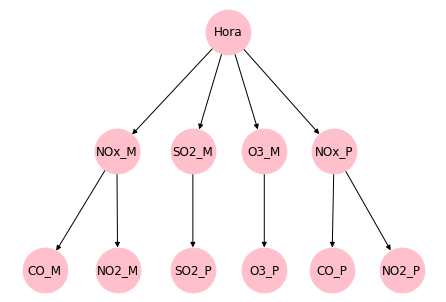

In [35]:
pomegranate_model = BayesianNetwork.from_samples(complete_data, algorithm='chow-liu')

for i, s in enumerate(pomegranate_model.states):
    s.name = str(list(complete_data)[i])

# plot_pomegranate_bn_pgvz(pomegranate_model)
plot_pomegranate_bn_nx(pomegranate_model)